# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

In [3]:
from utils import F_and_plots, reconstruct

In [4]:
prefix = ['20190604220531U_d', '20190604155532U_d','20190607122913U_AE']
l_p = len(prefix)
V = [np.load('Predictions_npy/cor'+prefix[i]+'.npy') for i in range(l_p)]

In [7]:
A = np.load('Predictions_npy/pred_'+prefix[0]+'.npy')
B = np.load('Predictions_npy/pred_'+prefix[1]+'.npy')
del(A)
del(B)

In [8]:
train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
train_generator_rnd =  Full_Diff_Generator(folder='Data3', batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)

def Get_Var(generator, header, var, op, y_v=False):
    idx = header.index(var)
    T=[]
    if(op==0):
        OP = lambda x: x[:,0, idx]
    if(op==-1):
        OP = lambda x: x[:,-1, idx]
    if(op==1):
        OP = lambda x: np.sum(abs(x[:,:, idx]), axis=1)
    if(op==2):
        OP = lambda x: np.max(abs(x[:,:, idx]), axis=1)
    if(op==3):
        OP = lambda x: np.mean(np.square(x[:,:, idx]), axis=1)
    if(op==10):
        OP = lambda x: np.mean( x[:,:32, idx])       
    if(op==11):
        OP = lambda x: np.mean( x[:,32:, idx])       
    if(not y_v):
        for x, _ in generator:
            T.append(OP(x))
    else:
        for _, y in generator:
            T.append(OP(y))
    T = np.array(T)    
    return(T)

In [10]:
D_var = dict()
xdim = train_generator.dimensions['x']
ydim = train_generator.dimensions['y']
I = ['fcld'+'mean','fcld'+'up','fcld'+'down'] 
J_op = [1,10,11]
for j, i in enumerate(I):
    D_var[i]= Get_Var(train_generator, header_x, 'fcld', J_op[j])
    D_var[i] = D_var[i].reshape(D_var[i].shape[0], ydim, xdim)
    D_var[i] = reconstruct(D_var[i])

ValueError: cannot reshape array of size 25 into shape (25,864,144)

In [ ]:
L=[[],[],[]]
for i in range(X.shape[1]):
    for j in range(len(V)):
        L[j].append(np.corrcoef(X[:,i], V[j].flatten())[0,1])
L = np.array(L)

In [15]:
flxd = Get_Var(train_generator, header_y, 'flxd', op=10, y_v=True)
flxu = Get_Var(train_generator, header_y, 'flxu', op=10, y_v=True)
flxu = flxu.reshape((flxu.shape[0],flxu.shape[1] ,flxu.shape[2] ,1  ))
flxd = flxd.reshape((flxd.shape[0],flxd.shape[1] ,flxd.shape[2] ,1  ))
flx = np.concatenate( (flxu, flxd), axis=-1)
del(flxd)
del(flxu)

In [20]:
def MSE(y,y0):
    m = np.mean(np.square(y-y0), axis=-1)
    m = np.mean(m, axis=-1)
    return(m)
    
V = [MSE(V[i], flx) for i in range(len(V))]
del(flx)

ValueError: operands could not be broadcast together with shapes (25,124416) (25,124416,72,2) 

In [21]:
xdim = train_generator.dimensions['x']
ydim = train_generator.dimensions['y']
for i in range(l_p):
    V[i] = V[i].reshape(V[i].shape[0], ydim,xdim)
    V[i] = reconstruct(V[i])

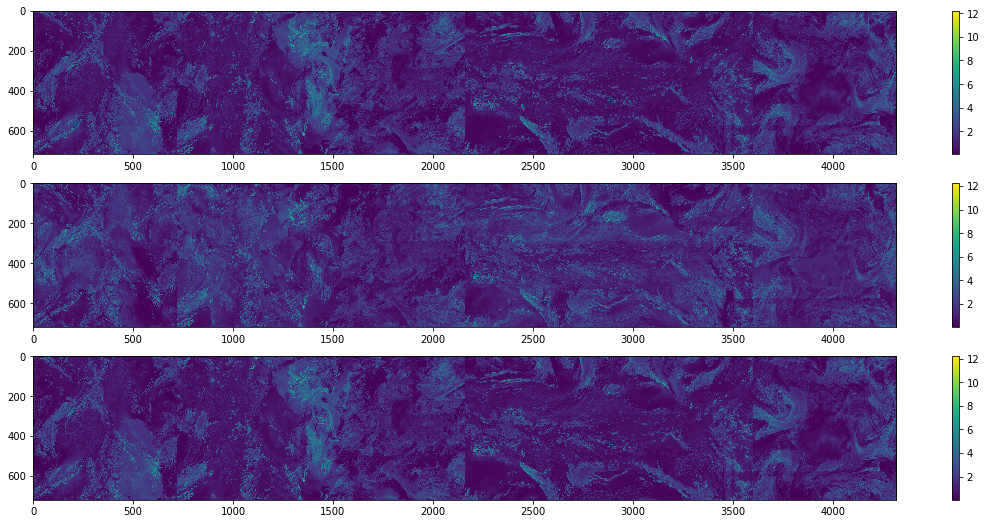

In [22]:
F = F_and_plots(figsize=(20,l_p*3), shape=(l_p,1))
F[0].imshow(V[0]); F.f.colorbar(plt.imshow(V[0]), ax=F[0]) #F.f.colorbar(mappable=plt.imshow(V[0]))
F[1].imshow(V[1]); F.f.colorbar(plt.imshow(V[0]), ax=F[1])
F[2].imshow(V[2]); F.f.colorbar(plt.imshow(V[0]), ax=F[2])

In [23]:
D_var = dict()
for i in ['ql','qi','q', 'emis', 'fcld', 't']:
    print(i)
    D_var[i] = Get_Var(train_generator, header_x, i, 1)
    D_var[i] = D_var[i].reshape(D_var[i].shape[0], ydim,xdim)
    D_var[i] = reconstruct(D_var[i])

ql
qi
q
emis
fcld
t


In [17]:
from sklearn.linear_model import LinearRegression

In [31]:
for i,v in enumerate(D_var):
    a,b = D_var[v].shape
    if(i==0):
        X=D_var[v].flatten()
        X=D_var[v].reshape(-1,1)
    else:
        
        X=np.concatenate((X, D_var[v].flatten().reshape(-1,1)), axis=-1)

In [35]:
L = LinearRegression().fit(X, V[0].flatten())

In [50]:
L

array([[-0.16122062, -0.00643003, -0.01770431,  0.2869465 ,  0.31218814,
        -0.01479525],
       [ 0.01411222, -0.06341726, -0.17838455, -0.15426037,  0.13890913,
         0.1740313 ],
       [-0.00641967,  0.01024643, -0.09853331, -0.06344208,  0.28766794,
         0.01410728]])

In [53]:
D_var.keys()

dict_keys(['ql', 'qi', 'q', 'emis', 'fcld', 't'])

In [1]:
F = F_and_plots(figsize=(20,15), shape=(2,4))
F[0].imshow(V[0]); F.f.colorbar(plt.imshow(V[0]), ax=F[0])

X=V[0].copy().flatten()
np.random.seed(0)
np.random.shuffle(X)
for i,v in enumerate(D_var):
    Y = D_var[v].copy().flatten()
    np.random.seed(0)
    np.random.shuffle(Y)
    F[i+1].scatter(Y[:500],X[:500])
    F[i+1].set_title(v)

NameError: name 'F_and_plots' is not defined

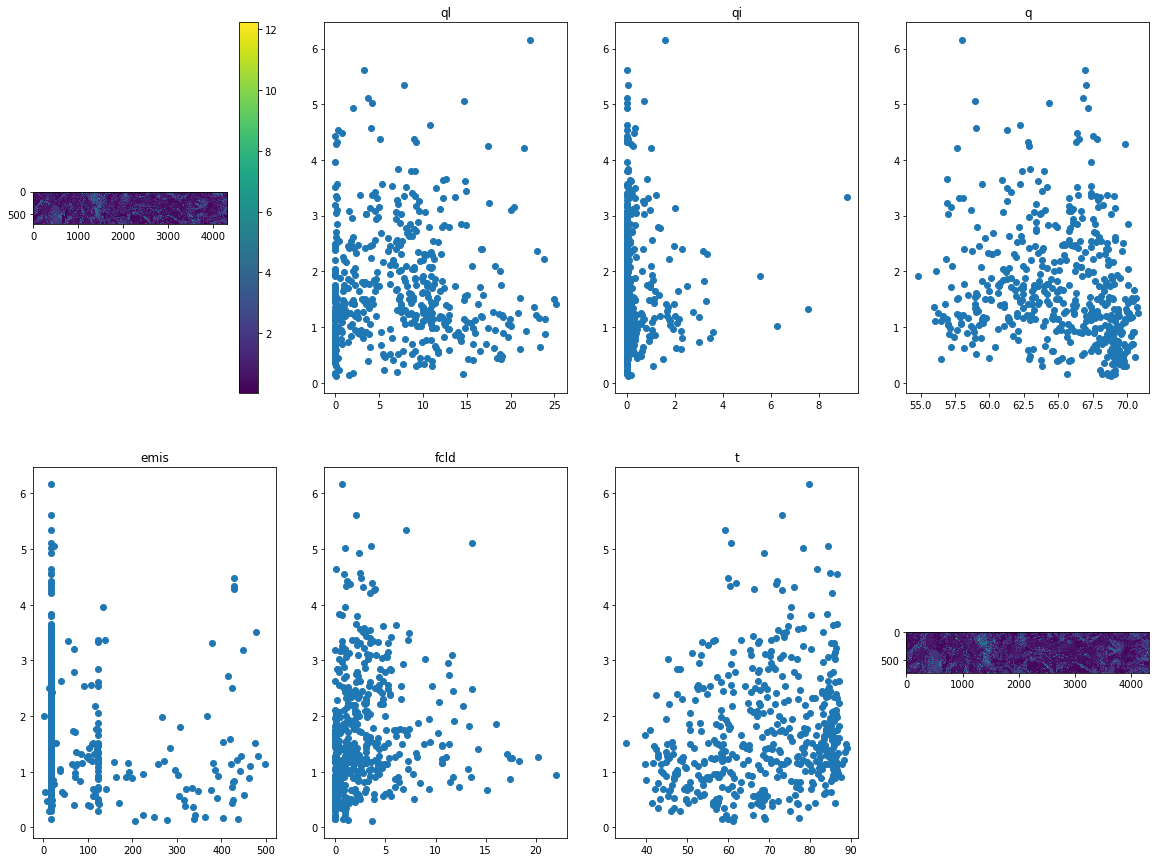

In [57]:
F = F_and_plots(figsize=(20,15), shape=(2,4))
F[0].imshow(V[0]); F.f.colorbar(plt.imshow(V[0]), ax=F[0])


j=500
X=V[1].copy().flatten()
np.random.seed(j)
np.random.shuffle(X)
for i,v in enumerate(D_var):
    Y = D_var[v].copy().flatten()
    np.random.seed(j)
    np.random.shuffle(Y)
    F[i+1].scatter(Y[:500],X[:500])
    F[i+1].set_title(v)

In [ ]:
['ql','qi','q', 'emis', 'fcld', 't']

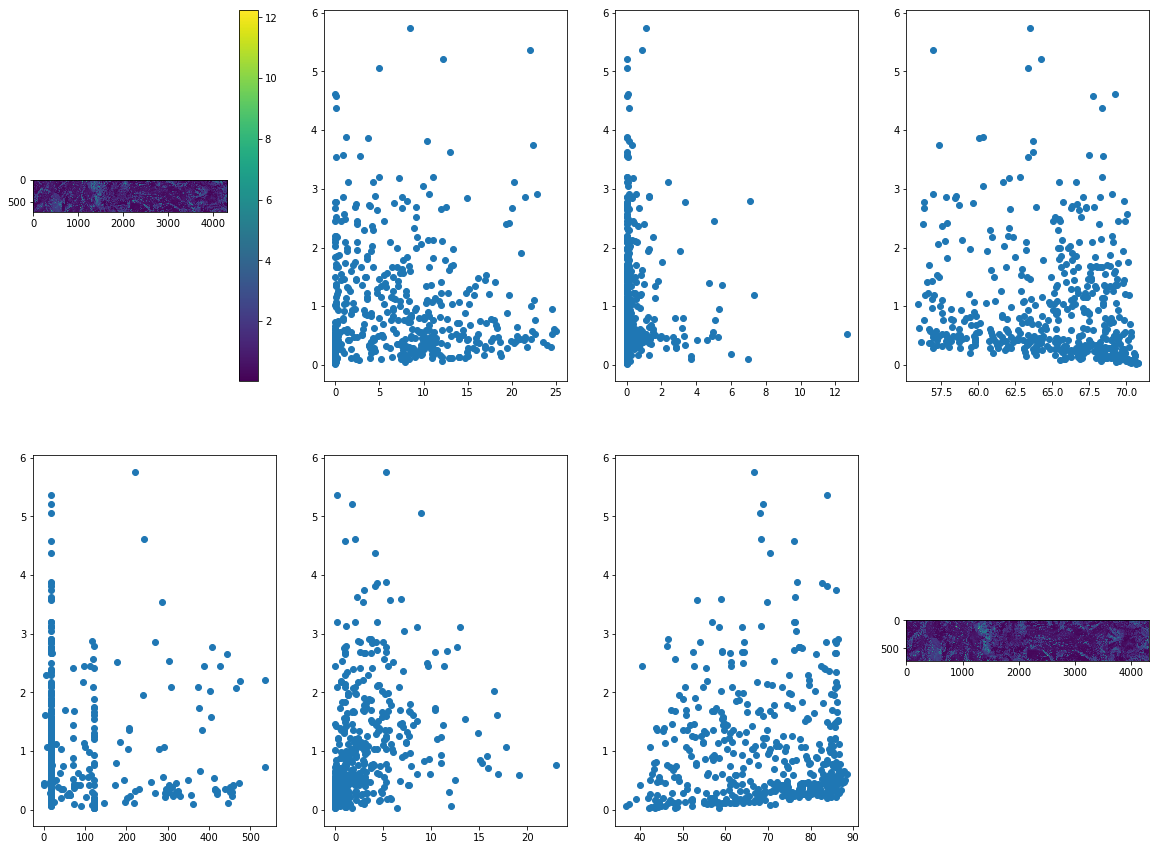

In [24]:
F = F_and_plots(figsize=(20,15), shape=(2,4))
F[0].imshow(V[0]); F.f.colorbar(plt.imshow(V[0]), ax=F[0])

X=V[2].copy().flatten()
np.random.seed(0)
np.random.shuffle(X)
for i,v in enumerate(D_var):
    Y = D_var[v].copy().flatten()
    np.random.seed(0)
    np.random.shuffle(Y)
    F[i+1].scatter(Y[:500],X[:500])

In [11]:
D_var_rnd = dict()
for i in ['ql','qi','q', 'emis']:
    print(i)
    D_var_rnd[i] = Get_Var(train_generator_rnd, header_x, i, 1)
    D_var_rnd[i] = D_var_rnd[i].reshape(D_var_rnd[i].shape[0], ydim,xdim)
    D_var_rnd[i] = reconstruct(D_var_rnd[i])

ql
qi
q
emis


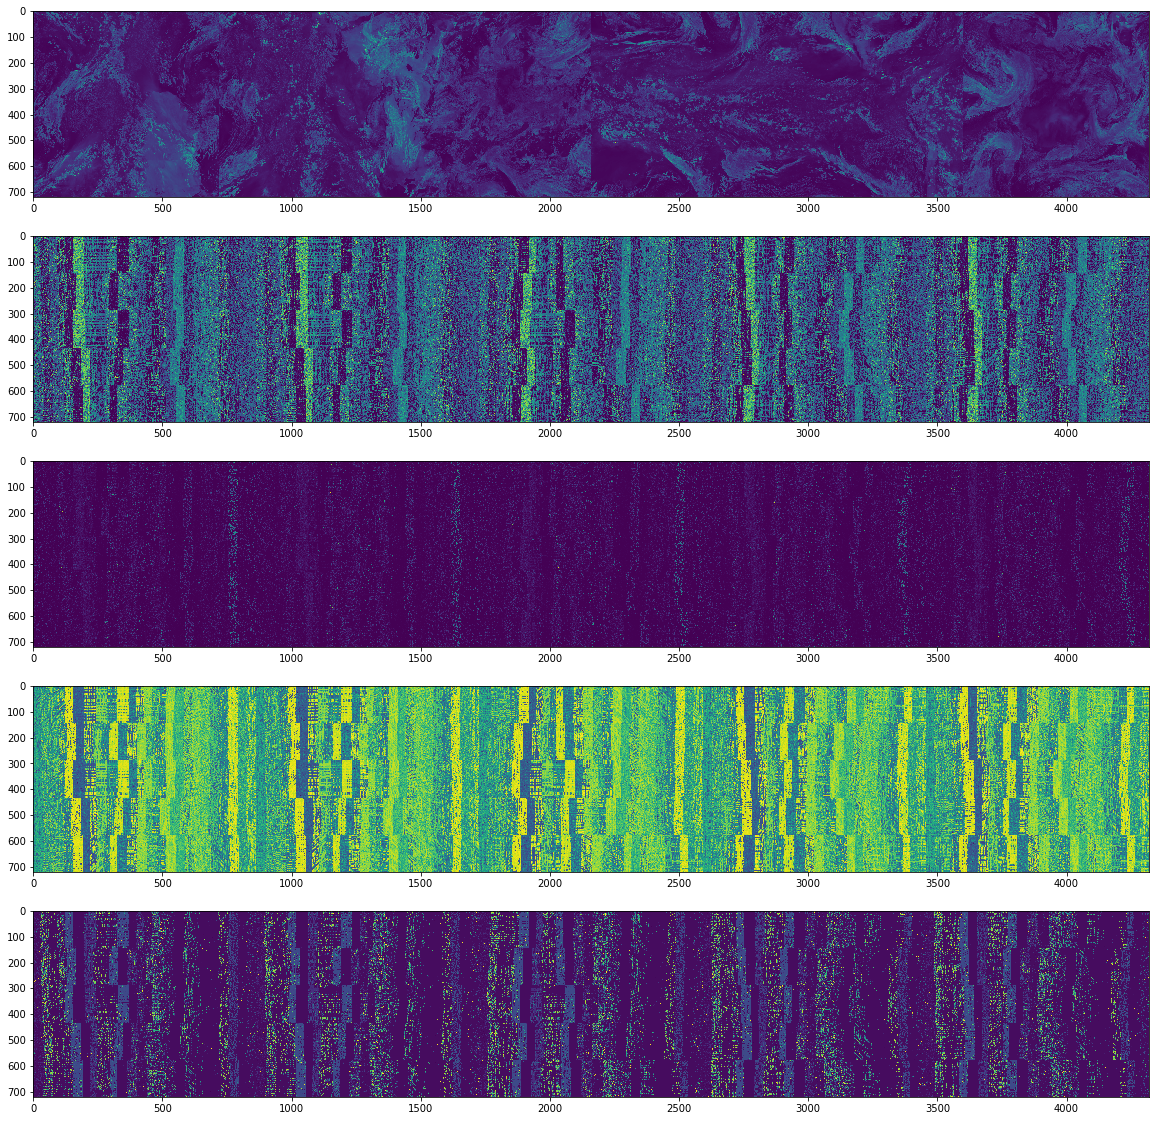

In [12]:
F = F_and_plots(figsize=(20,4*(len(D_var_rnd)+1)), shape=(len(D_var_rnd)+1, 1))
F[0].imshow(V[0]);
for i,v in enumerate(D_var_rnd):
    F[i+1].imshow(D_var_rnd[v]);

#### More complex (How?)
#### Use Tf to find max error input
#### Separate examples

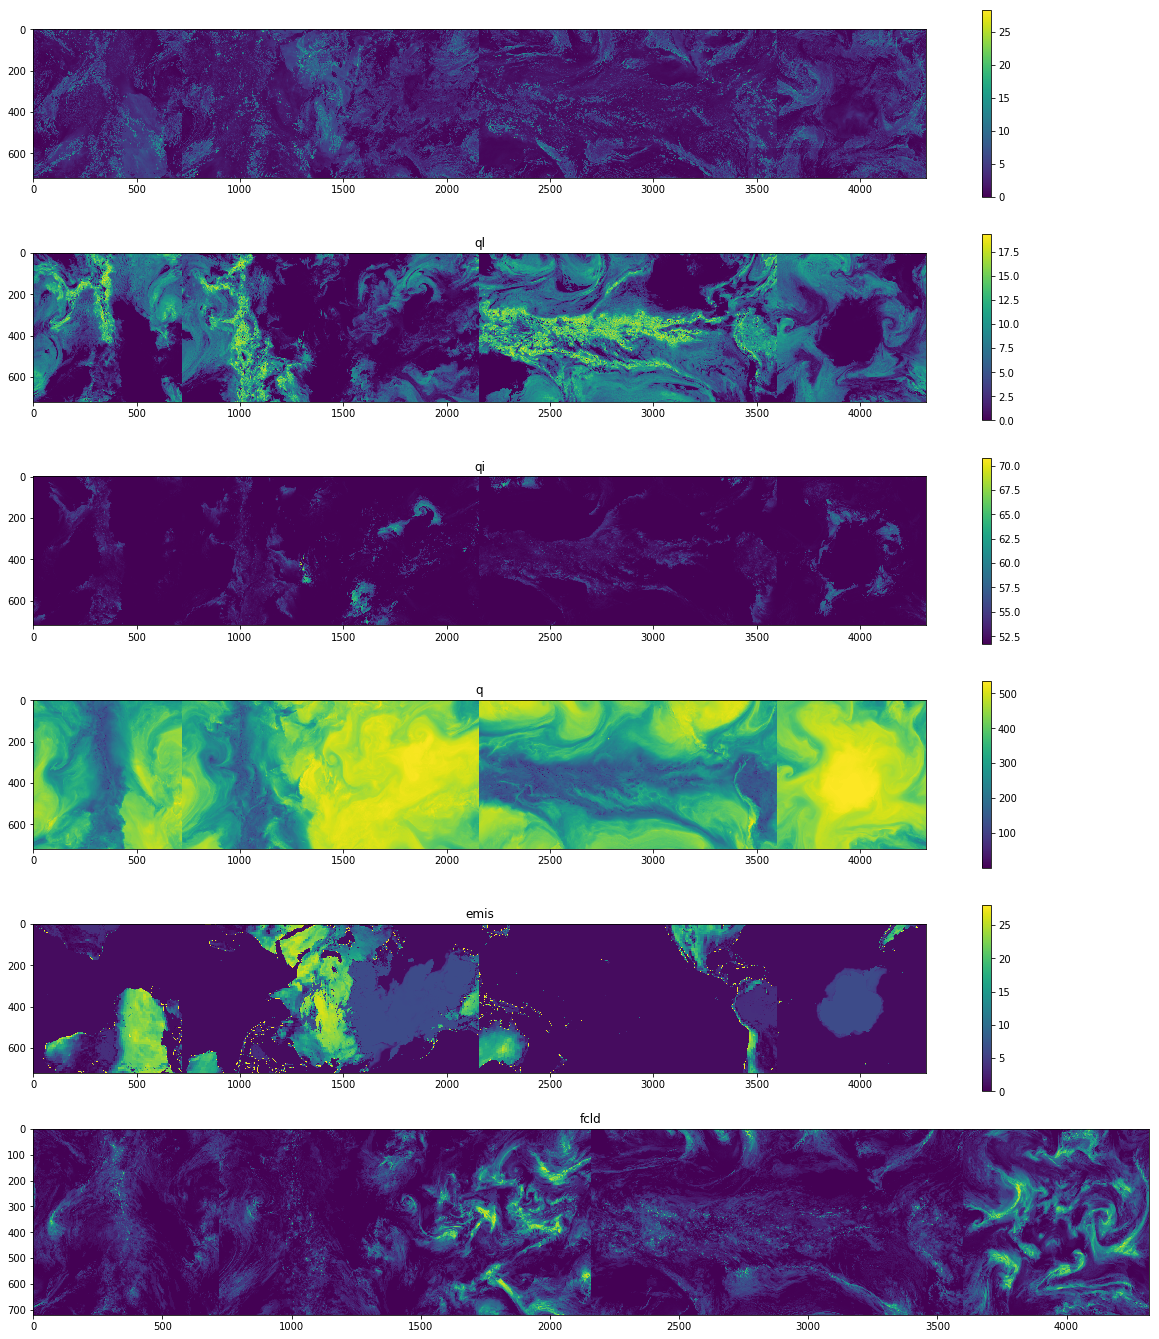

In [16]:
F = F_and_plots(figsize=(20,4*(len(D_var)+1)), shape=(len(D_var)+1, 1))
F[0].imshow(V[0]);
for i,v in enumerate(D_var):
    F[i+1].imshow(D_var[v]);
    F.f.colorbar(plt.imshow(D_var[v]), ax=F[i])
    F[i+1].set_title(v)

In [23]:
#print(np.corrcoef(V[0].flatten(),v0.flatten()))
#print(np.corrcoef(V[0].flatten(),D_out_var['flxd'].flatten()))
print(np.corrcoef(V[0].flatten(),D_var['fcld'].flatten()))
print(np.corrcoef(V[0].flatten(),D_var['qi'].flatten()))
print(np.corrcoef(V[0].flatten(),D_var['ql'].flatten()))

[[1.         0.32978789]
 [0.32978789 1.        ]]
[[ 1.        -0.0089104]
 [-0.0089104  1.       ]]
[[ 1.         -0.13540248]
 [-0.13540248  1.        ]]


In [30]:
D_out_var = dict()
for j in ['flxd', 'flxu']:
    print(j)
    D_out_var[j] = Get_Var(train_generator, header_y, j, 3, True)
    D_out_var[j] = D_out_var[j].reshape(D_out_var[j].shape[0], ydim,xdim)
    D_out_var[j] = reconstruct(D_out_var[j])   

flxd
flxu


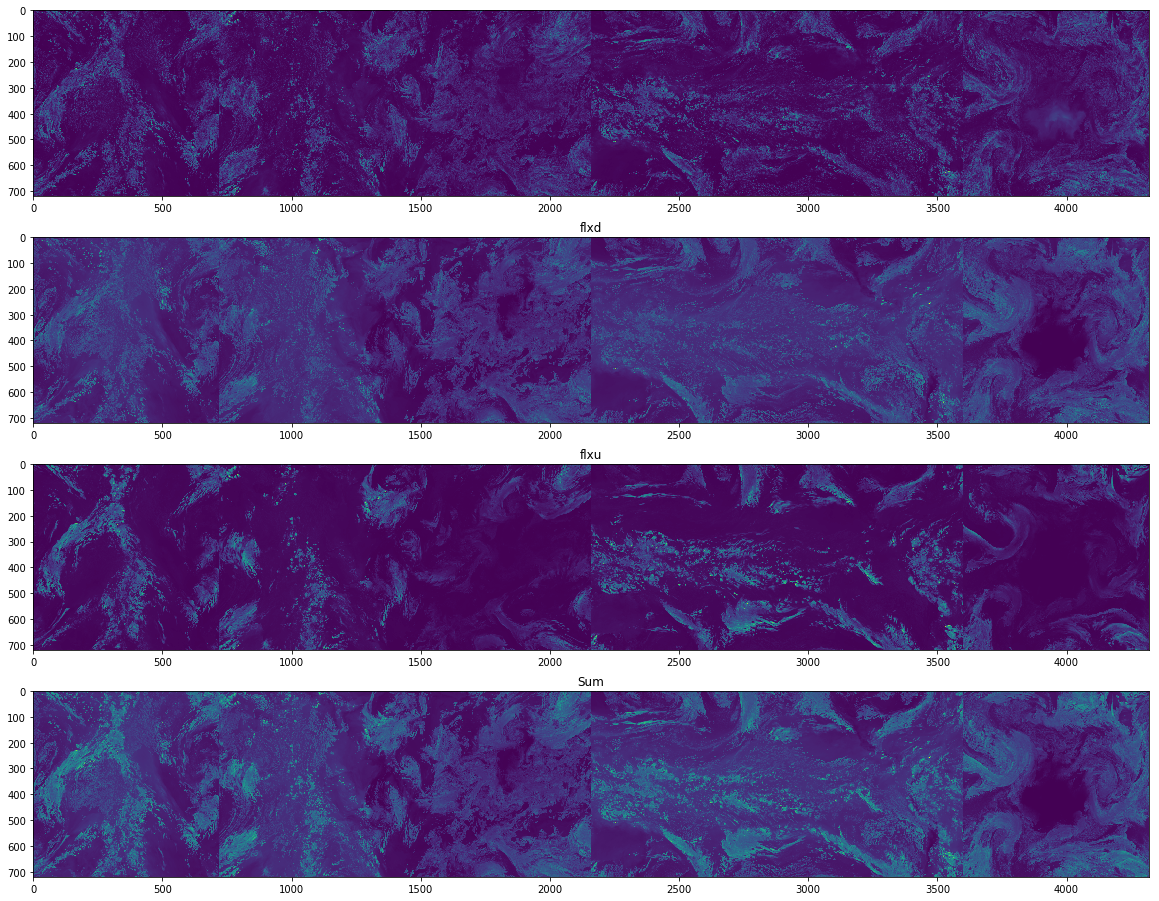

In [31]:
F = F_and_plots(figsize=(20,4*(len(D_out_var)+2)), shape=(len(D_out_var)+2, 1))
F[0].imshow(V[0]);
v0=[]
for i,v in enumerate(D_out_var):
    F[i+1].imshow(D_out_var[v]);
    F[i+1].set_title(v)
    v0.append(D_out_var[v]);
v0=np.sum(np.array(v0),axis=0)
F[-1].imshow(v0);
F[-1].set_title('Sum');

In [33]:
print(np.corrcoef(V[0].flatten(),v0.flatten()))
#print(np.corrcoef(V[0].flatten(),D_out_var['flxd'].flatten()))
print(np.corrcoef(V[0].flatten(),D_out_var['flxu'].flatten()))
print(np.corrcoef(V[0].flatten(),D_out_var['flxd'].flatten()))

[[1.         0.79472498]
 [0.79472498 1.        ]]
[[1.         0.61978147]
 [0.61978147 1.        ]]
[[1.         0.72131019]
 [0.72131019 1.        ]]


In [22]:
print(np.mean(D_out_var['flxd']))
print(np.mean(D_out_var['flxu']))

4.490982309794992
1.941057495758871


In [25]:
np.mean(V[0])

40.44501659981996

### Model construct

In [ ]:
F = F_and_plots(figsize=(20,4*(len(D_var)+1)), shape=(len(D_var)+1, 1))
F[0].imshow(V[0]);
for i,v in enumerate(D_var):
    F[i+1].imshow(D_var[v]);